# <center> Are Haters Just Hating?: A Statistical Analysis of CSGO Pro Gamers
<center> Sam Felsenfeld, Cindy Jia, Mark Levin </center>


#
### <center> What is Counterstrike: Global Offensive?</center>
Counterstrike: Global Offensive - or CS:GO for short - is a multiplayer first-person shooter game with millions of active players. In a game of CS:GO, players compete to kill the opposing team in a virtual shootout while trying to complete objectives like planting or defusing a bomb. While the game itself is fairly competitive, it also boasts a large professional scene where the top players compete in five person teams to be the best in the world. Major tournaments take place almost every week, leading to a constant trove of player data and game statistics.

<br>

#### Player skill
While there is often a clear consensus of which teams are the best during a given time period, the individual skill of players within these teams is often hard to connect to actual team performance: for example a team which has the consensus best player in the world at the time, Vitality, is currently ranked second behind Heroic, a team which has only a single player in the top 20 players of 2022. In a game like CS:GO, an individual's performance is often the deciding factor between winning and losing a match. When star players have slumps, there often seems to be a clear impact on team performance, leading to much criticism from the public.



Public opinion can often be a misrepresentation of the actual performance of public figures. In this analysis, we aim to determine whether the public perception that a player is either at the top of their game or on their way out is actually reality, or just something that people like to overemphasize.

## <center> Data Collection
In order to perform our analysis, we will pull data from 3 different sources.  First will be the raw player data itself. The only source that keeps player level statistics for all CS:GO pro games is hltv.org, a forum devoted to following the game.
The second data source we will be looking at is team ranking over time from esl.tv, a website devoted to ranking teams based on tournament wins. Each day the ESL api is updated with team rankings, making it extremely easy to scrape.
The last data source we used was from liquipedia.net, a wikipedia like website that provides information on CS:GO players. In CS:GO, players have different roles depending on which kind of weapon they use the most.  Since these roles heavily skew performance, liquipedia was used to determine which role each player had.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import requests
from bs4 import BeautifulSoup
import re
import threading
from tqdm import tqdm
from selenium import webdriver
from time import time
import os
from scipy.stats import linregress

## Scraping HLTV
Unfortunately, hltv.org is extremely hard to scrape, as it is gated behind cloudflare and a mix of other security measures designed to combat bots trying to access the forum. In order to access the player data, we use Selenium, which fully emulates a browser. From hltv, we scrape a list of all CS:GO players, as well as performance statistics like kills and deaths for every pro CS:GO game ever played by visiting every player page. This step takes by far the longest, at around 3 hours to run even when multithreaded. For convenience, predownloaded pages are stored in the /scraped pages directory.

In [3]:
### A function to download player data given a list of urls
def scrape_pages(pages, skip=True):
    driver = webdriver.Firefox()
    # skip downloading page if it is already found in ./scraped pages
    for name in tqdm(pages):
        t = time()
        url = "https://www.hltv.org/stats/players/matches/" + name
        if not skip or name.replace("/","") not in os.listdir("scraped pages"):
            driver.get(url)
            html = driver.page_source
            with open("scraped pages/{}".format(name.replace("/","")),"w", encoding="utf-8") as f:
                f.write(html)
                f.close()
            print("Scraped {}, took {} seconds".format(name,time()-t))
    driver.close()

# Download a list of pro CS:GO players from hltv
def scrape_names():
    # download player list if not already a local file
    if "players_page.html" not in os.listdir("."):
        driver = webdriver.Firefox()
        url = "https://www.hltv.org/stats/players/"
        driver.get(url)
        print("Scraping list of players")
        html = driver.page_source
        with open("players_page.html", "w", encoding="utf-8") as f:
            f.write(html)
            f.close()
        driver.close()
    else:
        print("List of hltv players already found")

# Credit: https://stackoverflow.com/questions/312443/how-do-i-split-a-list-into-equally-sized-chunks
# Simple function to split a list into evenly sized chunks
def chunks(lst, n):
    n = int(len(lst)/n)+1
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Function to scrape hltv
def scrape_hltv():
    n = 1 # number of threads, increasing threads didn't seem to decrease time on my weak computer
    scrape_names() # get player names and save
    pages = get_player_list("players_page.html") # read in player names
    threads = [threading.Thread(target=scrape_pages, args=([subset])) for subset in chunks(pages,n)]
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    print("Finished scraping")

# Find a list of players from the hltv html page
def get_player_list(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        bs = BeautifulSoup(f, features='lxml')
        rows = bs.find('table')
        pattern = r"/stats/players/(.*?)?\""
        return re.findall(pattern, str(rows))

scrape_hltv() ### Scrape all of hltv player data

List of hltv players already found


100%|██████████| 852/852 [00:00<00:00, 1370.26it/s]


Finished scraping


Here we take all of the scraped html pages and do some light data cleaning to combine them all into one large dataframe, which we then save to a csv for easier use, this takes about 20 minutes to run. Each entry in the resulting dataframe will correspond to a player's performance in a single game. We also precompute some useful stats like kill-to-death ratio which we will later use.

In [4]:
### Load data into dataframe from scraped html
# Skip of the processed csv is already present to save time
if "all games processed.csv" not in os.listdir("."):
    dfs = []
    for name in tqdm(os.listdir("scraped pages")):
        with open("scraped pages/"+name,'r') as f:
            try:
                bs = BeautifulSoup(f, features='lxml')
                rows = bs.find('table')
                df = pd.read_html(str(rows))[0]
                df = df.drop(df.columns[-2:], axis=1)
                df.columns=["Date", "Player team", "Opponent", "Map", "kd", "pm", "rating"]
                df["player name"] = re.sub("[0-9]*","", name) # Remove all numbers from player pages
                # This has the side effect of turning names like s1mple into smple

                dfs.append(df)
            except: # if there is an error in reading, we skip
                print("Skipping {}".format(name))
            f.close()

    full_frame = pd.concat(dfs, ignore_index=True)

    def get_kd(s):
        a = s.split(" - ")
        a[1] = 1 if int(a[1]) == 0 else int(a[1])
        return int(a[0])/int(a[1])

    # We store the kd ratio
    full_frame["kd ratio"] = full_frame["kd"].apply(get_kd)

    # Extract rounds won from hltv format
    full_frame["rounds won"] = full_frame["Player team"].apply(lambda s: int(s[-3:-1].replace("(","")))
    # Extract rounds lost
    full_frame["rounds lost"] = full_frame["Opponent"].apply(lambda s: int(s[-3:-1].replace("(","")))
    # Extract player team
    full_frame["Player team"] = full_frame["Player team"].apply(lambda s: s[:-4].strip())
    # Extract opponent team
    full_frame["Opponent"] = full_frame["Opponent"].apply(lambda s: s[:-4].strip())
    # Find total rounds player
    full_frame["Total rounds"] = full_frame["rounds won"] + full_frame["rounds lost"]
    # Some old ratings have a * to indicate a different system, we strip this
    full_frame['rating'] = full_frame['rating'].apply(lambda s: float(s.replace("*", "")))
    # Find if the player won the game
    full_frame['win'] = full_frame['rounds won'] > full_frame['rounds lost']
    # Map wins to 1 or -1
    full_frame['win'] = full_frame['win'].apply(lambda s: 1 if s else -1)
    full_frame.to_csv("all games processed.csv") # Save our csv
else:
    print("Processed games already found, skipping")

Processed games already found, skipping


## Scraping team rankings and Imputation
Scraping data from pro.eslgaming.com/worldranking/csgo/rankings/ is much easier since they provide an API that responds to date queries with json containing a list of team rankings on that day. In order to download data we just query the days we are interested in.  We store the data in a dictionary that takes in team name and returns another dictionary that takes in a particular date in order to determine rank.  Additionally, some days have missing rankings, so if possible we imputate the missing data with a simple linear regression between two surrounding data points in time.

In [2]:
### Scrape all team rankings and put it in a big dictionary ###
if "team_rankings.json" not in os.listdir("."):
    url = "https://cdn1.api.esl.tv/csgo/worldranking/teamhistory/rankings?date="
    rankings_team_date = {}
    # Come up with our date range, starting in 2016 and ending at modern day
    dates = pd.date_range(start="2015-12-28", end="2023-5-8")
    for date in tqdm(dates):
        # make our json query
        r = requests.get(url + date.strftime("%y-%m-%d"))
        try:
            for team in r.json()["items"]:
                try: # append this ranking to our team's dictionary at this date
                    rankings_team_date[team["teaminfo"]["name"]][date.strftime("%y-%m-%d")] = team["power_rank"]
                except: # We need to make a new entry for team
                    rankings_team_date[team["teaminfo"]["name"]] = {}
                    rankings_team_date[team["teaminfo"]["name"]][date.strftime("%y-%m-%d")] = team["power_rank"]
        except: # sometimes a day is not recorded
            ...
    with open("team_rankings.json","w") as f:
        json.dump(rankings_team_date, f)

else:
    print("found team rankings file, reading")
    with open("team_rankings.json",'r') as f:
        rankings_team_date = json.load(f)

found team rankings file, reading


## Data cleaning for ranking
Because the ESL data contains many days where there is no ranking, we use linear interpolation in order to determine what a team rank for unreported days is.  This is done by for each team and for each missing data point, we fit a line to the two datapoints before and after the missing one.  We fill in the missing vlaues according to what this linear model predicts.

In [2]:
### Clean and fill in missing data with linear interpolation
if "team_rankings_fixed.json" not in os.listdir("."):
    missing_points = 0
    for team in tqdm(rankings_team_date.keys()):
        fixed_rankings = {}
        ranking = rankings_team_date[team]

        keys = list(ranking.keys())
        for i in range(len(keys) - 1):
            delta = pd.to_datetime(keys[i+1], yearfirst=True) - pd.to_datetime(keys[i], yearfirst=True)
            if 1 < delta.days < 60:
                slope = (ranking[keys[i+1]] - ranking[keys[i]])/delta.days
                start_date = pd.to_datetime(keys[i], yearfirst=True)
                for j in range(0,delta.days+1):
                    target_date = start_date + pd.Timedelta(j,'d')
                    fixed_rankings[target_date.strftime("%y-%m-%d")] = int(slope * j + ranking[keys[i]])
                missing_points += 1
            else:
                fixed_rankings[keys[i]] = ranking[keys[i]]
        try:
            fixed_rankings[keys[i+1]] = ranking[keys[i+1]]
        except: #Teams with only one match played
            ...
        rankings_team_date[team] = fixed_rankings

    with open("team_rankings_fixed.json","w") as f:
        json.dump(rankings_team_date, f)
else:
    with open("team_rankings_fixed.json", 'r') as f:
        rankings_team_date = json.load(f)
        print("Found ranking file")

Found ranking file


## Lookup function
Here we define a function to lookup a team ranking for a given day. Since the ESL team names don't match 1 to 1 with the hltv database, we look for team names that are close in order to determine what series to look at.

In [3]:
### Function to lookup a team ranking at a specific date
def lookup_ranking(team, date):
    match = ""
    for name in rankings_team_date.keys():
        if team.lower() in name.lower() or name.lower() in team.lower():
            match = name
    d = pd.to_datetime(date,dayfirst=True)
    try:
        val = rankings_team_date[match][d.strftime("%y-%m-%d")]
    except:
        val = int(np.mean(rankings_team_date[match].values()))
    return val

### Example of adding in the team ranking for Faze
sub = df[df["Player team"] == "FaZe"]
sub["rank"] = sub["Date"].apply(lambda x: lookup_ranking("FaZe", x))
sub.head()

NameError: name 'df' is not defined

## Scraping Role List
Here we scrape a list of all players who use the sniper weapon from liquipedia, this weapon is more difficult to obtain and more powerful, so usually there is only one player who uses it in each pro team. This data is needed to account for the corresponding difference in performance.

In [4]:
### Get a list of awpers from liquipedia
### Getting awpers
urls = ["https://liquipedia.net/counterstrike/Category:AWPers",
        "https://liquipedia.net/counterstrike/index.php?title=Category:AWPers&pagefrom=Galantis#mw-pages",
        "https://liquipedia.net/counterstrike/index.php?title=Category:AWPers&pagefrom=Powell#mw-pages"]

awpers = {"~~~~"} # Create a lookup table of awpers
for url in urls:
    res = requests.get(url)
    bs = BeautifulSoup(res.content)
    ### Toggle system to only get from first to last player on each page
    toggle = False
    for l in bs.find_all("a"):
        if "Ace" in l.get('href') or "/Galantis" in l.get('href') or "/Powell" in l.get('href'):
            toggle=True
        if toggle:
            # When adding names of awpers to the table, we are extremely loose with what counts
            # adding several variations to make sure that when we lookup names from different data
            # sources we garuntee a match if we should have one.
            s = l.get('href')[15:].lower()
            awpers.add(s) # Add base name
            if "_" in s:
                s = s[:s.find("_")] # add name with extra annotations removed
            awpers.add(s)
            s = re.sub(r'[^a-zA-Z0-9]', '', s)# Remove extra characters
            awpers.add(s)
        if "Gafolo" in l.get('href') or "Potei" in l.get('href') or "ZywOo" in l.get('href'):
            toggle=False

# Dump data to a json file for future reference
with open("awpers.json", 'w') as file:
    json.dump(list(awpers), file)
    

## <center> Data Processing

Here we read in our previously generated data frame and start to combine it with our other data, adding in data for player role.

In [5]:
df = pd.read_csv("all games processed.csv", sep=',')
with open('awpers.json') as file:
    awpers = json.load(file)
df= df.drop('Unnamed: 0', axis=1)

# cleaning data and labeling awpers
df['rating'] = df['rating'].apply(lambda s: float(s.replace("*", "")))
df['Awper'] = df['player name'].apply(lambda s: s in awpers)
df

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper
0,31/10/20,Golden Knights,Lyngby Vikings,nuke,17 - 21,-4,0.83,fitch,0.809524,13,16,29,False
1,31/10/20,Golden Knights,Lyngby Vikings,mrg,14 - 20,-6,0.77,fitch,0.700000,16,12,28,False
2,19/5/20,Syman,SG.pro,trn,8 - 20,-12,0.56,fitch,0.400000,13,16,29,False
3,19/5/20,Syman,SG.pro,mrg,11 - 18,-7,0.61,fitch,0.611111,10,16,26,False
4,18/5/20,Syman,LDLC,d2,13 - 19,-6,0.87,fitch,0.684211,11,16,27,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
748822,9/11/15,eSuba,neXtPlease!,cch,16 - 22,-6,0.80,montty,0.727273,11,16,27,False
748823,9/11/15,eSuba,neXtPlease!,inf,19 - 18,1,1.06,montty,1.055556,16,10,26,False
748824,7/11/15,eSuba,nEophyte,inf,17 - 17,0,0.95,montty,1.000000,9,16,25,False
748825,7/11/15,eSuba,nEophyte,cch,21 - 20,1,1.05,montty,1.050000,11,16,27,False


In [6]:
players = df['player name'].unique()
teams = df['Player team'].unique()

In [7]:
df = df.assign(Date = pd.to_datetime(df['Date']))
df["round difference"] = (df['rounds won'] - df['rounds lost'])
df.sort_values('Date').head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper,round difference
380533,2012-01-11,dotpiXels,CPLAY,mrg,15 - 16,-1,0.87,legija,0.937500,16,6,22,False,10
474590,2012-01-11,gamed!de,iPLAY,trn,22 - 12,10,1.47,syrson,1.833333,16,7,23,True,9
469648,2012-01-11,ALTERNATE aTTaX,CPLAY,trn,15 - 12,3,0.96,krystal,1.250000,16,9,25,False,7
438636,2012-01-11,dotpiXels,CPLAY,mrg,32 - 13,19,2.19,tabsen,2.461538,16,6,22,False,10
485888,2012-01-12,BuyKey,ESC,inf,26 - 16,10,1.57,scream,1.625000,16,7,23,False,9


,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper,standard rating
0,2020-10-31,Golden Knights,Lyngby Vikings,nuke,17 - 21,-4,0.83,fitch,0.809524,13,16,29,False,-0.745959
1,2020-10-31,Golden Knights,Lyngby Vikings,mrg,14 - 20,-6,0.77,fitch,0.700000,16,12,28,False,-0.937575
2,2020-05-19,Syman,SG.pro,trn,8 - 20,-12,0.56,fitch,0.400000,13,16,29,False,-1.608230
3,2020-05-19,Syman,SG.pro,mrg,11 - 18,-7,0.61,fitch,0.611111,10,16,26,False,-1.448550
4,2020-05-18,Syman,LDLC,d2,13 - 19,-6,0.87,fitch,0.684211,11,16,27,False,-0.618215


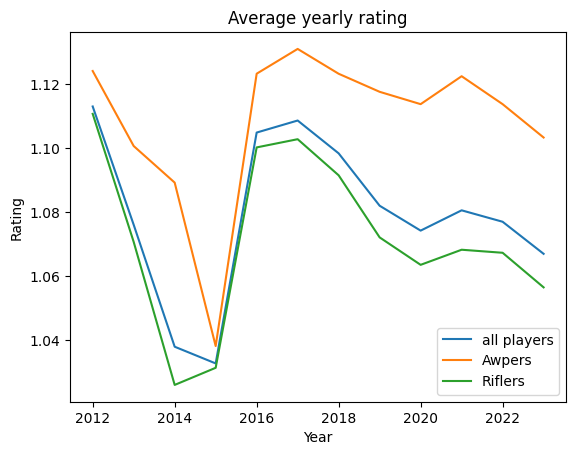

In [11]:
x = np.arange(2012, 2024)
y = []
y_awp = []
y_rifle = []

# determining mean performance per year and standardizing rating
for year in x:
    date_mask = (dt.datetime(year,1,1) < df['Date']) & (df['Date'] < dt.datetime(year,12,31))
    y.append(df[date_mask]['rating'].mean())
    mean_awp = df[date_mask & df['Awper']]['rating'].mean()
    y_awp.append(mean_awp)
    mean_rifle = df[date_mask & ~df['Awper']]['rating'].mean()
    y_rifle.append(mean_rifle)

    std_awp = df[date_mask & df['Awper']]['rating'].std()
    std_rifle = df[date_mask & ~df['Awper']]['rating'].std()
    
    df.loc[date_mask & df['Awper'],'standard rating'] = (df['rating']-mean_awp) / std_awp
    df.loc[date_mask & ~df['Awper'],'standard rating'] = (df['rating']-mean_rifle) / std_rifle

plt.plot(x,y,label = 'all players')
plt.plot(x,y_awp,label = 'Awpers')
plt.plot(x,y_rifle,label = 'Riflers')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Rating")
plt.title("Average yearly rating")
df.head()

## Hypothesis Testing

Here in order to help quantify how good player performance is, we look at how well corellated a player's rating is with winning rounds

In [55]:
win_correlation = {}
subset = df[(df['Date'] > dt.datetime(2022,9,7)) & (df['Date'] < dt.datetime(2025,1,7))]
subset = df
for player in tqdm(players):
    filtered = subset[subset["player name"] == player]
    try:
        slope, intercept, r_value, p_value, std_err = linregress(filtered["rating"], filtered["round difference"])
        win_correlation[player] = r_value
    except:
        ...


100%|██████████| 839/839 [00:27<00:00, 30.52it/s]


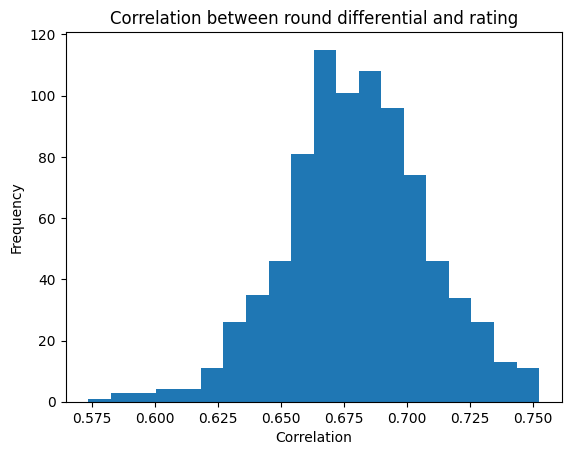

In [59]:
standard = (np.array(list(win_correlation.values()))-np.mean(list(win_correlation.values())))/np.std(list(win_correlation.values()))
standard_correl = dict(zip(win_correlation.keys(), standard))



plt.hist(win_correlation.values(), bins=20)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Correlation between round differential and rating")
plt.show()